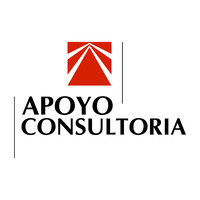

# Nowcast

Esta libreria construye la estimacion de nowcast usando la metodologia especificada en el punto XX.XX del informe. Se busca obtener proyecciones trimestrales usando informacion mensual y que se pueda manejar el problema de informacion faltante sin tener que realizar proyecciones de las variables faltantes.

Esta libreria realiza la estimacion yb la evaluación, pero no la proyeccion, la cual se realiza en la libreria proyeccion


In [10]:
import pykalman as kalman
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os

from ipynb.fs.defs.ConstruccionBasedeDatos import BasedeDatos

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [11]:
rutaOrigen = 'inputs/'
rutaDestino = 'resultados/'
rutaModelos = 'model_nowcast/'


### Variables a proyectar en frecuencia mensual

In [12]:
y = ['imae_Mensual_VariacionAnual']

X = [ 'ipc1_trp_Mensual_VariacionAnual',
  ]

### Construccion de Base de datos

In [13]:
bd_mensual_t,bd_trimestral_t,bd_anual_t,bd_all = BasedeDatos(rutaOrigen + 'bd_Panama.xlsx')

###  Filtro de Kalman

In [14]:
def kalman_fed_nyc(bd_all, X, y, n_factors, params,initial_state_mean,initial_state_covariance, test_size):
    import numpy as numpy
    from pykalman import KalmanFilter

    n_vars = len(y + X)
    
    
    ##############################################################################
    #Data
    
    bd = bd_all[y + X]
    bd = bd.dropna(how='all')
    
    size_drop = int(bd.shape[0]/3)
    
    bd = bd.drop(bd[:size_drop].index[np.sum(bd[:size_drop].isna(),axis = 1)>0])

    #Fijando base de referencia  en caso se haga un ejercicio de train test
    bd_data = bd[y]
    
    
    #No se recibe informacion test_size periodos
    if test_size>0:
        bd.loc[-test_size:,y] = np.nan
    
    ###############################################################################
    #Demean data
    
    mean = bd.mean()
    
    bd_demean = pd.DataFrame()
    
    for i in bd.columns:
        bd_demean[i] =  bd[i] - mean[i]
    
    ################################################################################
    #Llenando data faltante

    bd_demean = bd_demean.fillna(0)

    #Parametros
    phi   = params[0]
    var_m = params[1]
    rho   = params[2]
    var_e = params[3]
    beta  = params[4]

    ###############################################
    #Matriz de observables

    H = []

    for date in bd_demean.index:
        aux = np.zeros([n_vars,n_factors+n_vars])
        i_aux = np.eye(n_vars)
        for i_var,var in enumerate(bd_demean.columns):
            if (bd_demean.loc[date,var] != 0):
                aux[i_var,:] = np.array(list(beta[i_var,:]) + list(i_aux[i_var,:]))
        H.append(aux)



    observation_offset = [0] * n_vars
    observation_matrix = np.array(H)
    observation_covariance =  np.zeros([n_vars,n_vars])

    H_ = np.zeros([n_vars,n_factors+n_vars])
    H_[:,:n_factors] = beta
    H_[:,n_factors:] = np.eye(n_vars)
    
    ###############################################
    #Transicion

    #Interceptos
    transition_offset = [0] * (n_factors + n_vars)

    #Matriz de transicion
    transition_matrix = np.zeros([n_factors + n_vars,n_factors + n_vars])
    transition_matrix[:n_factors,:n_factors] = np.diag(phi)
    transition_matrix[n_factors:,n_factors:] = np.diag(rho)



    #Varianzas 

    transition_covariance = np.zeros([n_factors + n_vars,n_factors + n_vars])
    transition_covariance[:n_factors,:n_factors] = np.diag(var_m)
    transition_covariance[n_factors:,n_factors:] = np.diag(var_e)

    ###############################################
    #Estados iniciales
    initial_state_mean = np.zeros([n_factors + n_vars])
    initial_state_covariance = np.eye(n_factors + n_vars) * 0.01**2

    # Creando filtro
    kf = KalmanFilter(
        transition_matrix, observation_matrix, 
        transition_covariance, observation_covariance,
        transition_offset,observation_offset,
        initial_state_mean, initial_state_covariance
        ,random_state=1109
    )

    ll = kf.loglikelihood(bd_demean)

    bd_S = pd.DataFrame(kf.smooth(bd_demean[y + X])[0], index = bd_demean.index).rename(columns = lambda y: 'NoObservale_Suavizada_' + str(y))
    bd_F = pd.DataFrame(kf.filter(bd_demean[y + X])[0], index = bd_demean.index).rename(columns = lambda y: 'NoObservale_Filtrada_' + str(y))
    bd_P = pd.DataFrame(kf.filter(bd_demean[y + X])[0] @ np.transpose(H_),index = bd_demean.index, columns = bd_demean.columns)
    
    
    for i in bd_P.columns:
        bd_P[i] = bd_P + mean[i]
    
    
    return ll, kf, bd_S, bd_F, bd_P, bd, bd_data

    

### Transformacion de hiper parametros

In [15]:
def t_params(h_params,n_vars,n_factors):
    
    phi = []
    for x in h_params[0:n_factors]:
        phi.append(x/(1+abs(x)))
    
    var_m = []
    for x in h_params[n_factors:2*n_factors]:
        var_m.append(x**2)
    
    
    rho = []
    for x in h_params[2*n_factors:2*n_factors+n_vars]:
        rho.append(x/(1+abs(x)))
    
    
    var_e = []
    for x in h_params[2*n_factors+n_vars:2*n_factors+2*n_vars]:
        var_e.append(x**2)
    
    
    beta = np.array(h_params[2*n_factors+2*n_vars:]).reshape(n_vars,n_factors)
    
    params = [phi,var_m,rho,var_e,beta]
    
    return params



### Transformacion inversa

In [16]:

def t_inv_param(params):
    phi = params[0]
    var_m = params[1]
    rho = params[2]
    var_e = params[3]
    beta = params[4]
    
    
    h_params = []
    
    for x in phi:
        h_params.append(x/(1-x))
    
    
    for x in var_m:
        h_params.append(x**0.5)
    
    
    for x in rho:
        h_params.append(x/(1-x))
    
    
    for x in var_e:
        h_params.append(x**0.5)
    
    
    
    h_params = h_params + list(beta.flat[:])

    return h_params

In [17]:

def set_init_params(bd, X, y, n_factors,test_size):
    from sklearn.decomposition import PCA
    from sklearn.linear_model import LinearRegression

    n_vars = len(y + X)
    
    bd = bd_all[y + X]
    bd = bd.dropna()
    
  
    
    #############################################################
    #Componentes Principales
    #############################################################
    
    PCA_IC = PCA(n_components=n_factors)
    lin_reg = LinearRegression(fit_intercept = False)
    
    PC_IC = PCA_IC.fit_transform(bd[y+X])

    
    #Beta
    beta_ic = np.transpose(PCA_IC.components_)

    
    #Phi y sigma_m
    phi_ic = []
    var_m_ic = []


    for j in range(n_factors):

        lin_reg.fit(PC_IC[:-1,j].reshape(-1,1),PC_IC[1:,j].reshape(-1,1))
        phi_ic.append(lin_reg.coef_[0,0])
        var_m_ic.append(np.var(PC_IC[:,j])*(1-lin_reg.coef_[0,0]**2))

    
    #Errores de prediccion
    
    rho_ic = []
    var_e_ic = []
    error = bd.values - PCA_IC.inverse_transform(PC_IC)
    
    for j in range(n_vars):
        lin_reg.fit(error[:-1,j].reshape(-1,1),error[1:,j].reshape(-1,1))
        rho_ic.append(lin_reg.coef_[0,0])
        var_e_ic.append(np.var(error[:-1,j])*(1-lin_reg.coef_[0,0]**2))
    
    
    initial_state_mean = PC_IC[0,:]
    initial_state_covariance = np.diag(np.var(PC_IC,axis=0))
    
    params_ic = [phi_ic,var_m_ic,rho_ic,var_e_ic,beta_ic]
        
    h_params_ic =t_inv_param(params_ic)
    
    return params_ic, h_params_ic, initial_state_mean, initial_state_covariance

# Estimacion y Resultados

La estimacion del modelo se realiza usando el método de máxima verosimilitud, se busca maximizar la probabilidad de la ocurrencia de las variables, dados los parametros. Los resultados se guardan en un excel que luego será usado como insumo para la interpolación final del modelo.

Para asegurar que el maximo hallado es uno global se usan distintos puntos iniciales para realizar la estimación.

In [18]:
test_size = 30
n_factors= 1
n_vars = len(X+y)


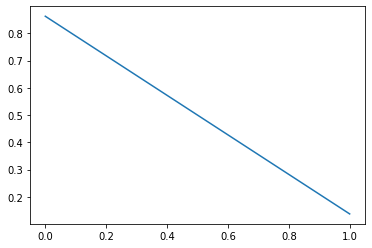

In [19]:
from sklearn.decomposition import PCA
PCA_ = PCA(n_components=bd_all[y + X].shape[1])
PCA_.fit(bd_all[y+X].dropna())
plt.plot(PCA_.explained_variance_ratio_)

In [20]:
params_ic, h_params_ic_pc, initial_state_mean, initial_state_covariance= set_init_params(bd_all, X, y, n_factors,test_size)

In [21]:
ll, kf, bd_S,bd_F, bd_P, bd,bd_data = kalman_fed_nyc(bd_all,X,y,n_factors,params_ic,
                                             initial_state_mean,initial_state_covariance,test_size)


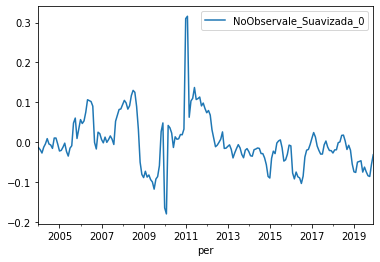

In [22]:
bd_S[bd_S.columns[0:n_factors]].plot()

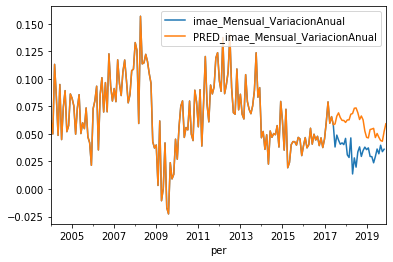

In [23]:
bd_data.join(bd_P[y].rename(columns = lambda y: 'PRED_' + y)).plot()
plt.show()

In [24]:
bd_data.join(bd_P[y].rename(columns = lambda y: 'PRED_' + y))[-12:]

,imae_Mensual_VariacionAnual,PRED_imae_Mensual_VariacionAnual
per,,
2019-01-01,0.035738,0.046907
2019-02-01,0.037358,0.046396
2019-03-01,0.029596,0.054007
2019-04-01,0.029352,0.054471
2019-05-01,0.023801,0.055083
2019-06-01,0.029463,0.046727
2019-07-01,0.036311,0.050409
2019-08-01,0.031975,0.046939
2019-09-01,0.039755,0.044043


In [25]:
from numdifftools import Jacobian, Hessian
from scipy.optimize import minimize


z_min = lambda params: -kalman_fed_nyc(bd_all,X,y,n_factors,t_params(params,len(X+y),n_factors),
                                       initial_state_mean,initial_state_covariance,test_size)[0]
z_hess = lambda params: -kalman_fed_nyc(bd_all,X,y,n_factors,params,
                                        initial_state_mean,initial_state_covariance,test_size)[0]

LogLikelihood = np.Inf

x0 = h_params_ic_pc
print(x0)
x_opt_ = minimize(z_min, x0, method='Nelder-Mead', options={'disp': True,'maxiter':10000})


[4.338191178714816, 0.0387337949234089, 0.919067311190015, 0.9190673111900161, 0.022357107021909673, 0.006764231125677649, 0.2895897759749838, 0.9571508562660115]
Optimization terminated successfully.
         Current function value: -951.543826
         Iterations: 2820
         Function evaluations: 4066


In [26]:
ll, kf, bd_S,bd_F, bd_P, bd, bd_data = kalman_fed_nyc(bd_all,X,y,n_factors,t_params(x_opt_.x,len(X+y),n_factors),
                                             initial_state_mean,initial_state_covariance,0)

### Guardando el modelo como una lista

In [38]:
Nowcast_model = [X,y,n_factors,t_params(x_opt_.x,len(X+y),n_factors),initial_state_mean,initial_state_covariance, bd, bd_data]

import pickle

with open(rutaModelos + 'nowcast_model.pkl', 'wb') as f:
    pickle.dump(Nowcast_model, f)

In [28]:
bd_data.join(bd_P[y].rename(columns = lambda y: 'PRED_' + y))

,imae_Mensual_VariacionAnual,PRED_imae_Mensual_VariacionAnual
per,,
2004-01-01,0.061897,0.061897
2004-02-01,0.049983,0.049983
2004-03-01,0.113209,0.113209
2004-04-01,0.083952,0.083952
2004-05-01,0.048694,0.048694
...,...,...
2019-08-01,0.031975,0.031975
2019-09-01,0.039755,0.039755
2019-10-01,0.033907,0.033907


### Evaluacion Proyecciones

In [29]:

bd_forecast_one = pd.DataFrame()
bd_forecast_two = pd.DataFrame()
bd_forecast_three = pd.DataFrame()
for t in range(test_size,0,-1):
    _, _, _,_, bd_P, _, bd_data = kalman_fed_nyc(bd_all,X,y,n_factors,t_params(x_opt_.x,len(X+y),n_factors),
                                             initial_state_mean,initial_state_covariance,t)
    
    
    #bd_P[-t-1:][y].rename(columns = lambda y: 'PRED' + y).join(bd_data[-t-1:]).plot()
    if -t+1 < 0:
        bd_forecast_one = bd_forecast_one.append(bd_P[-t:-t+1][y].rename(columns = lambda y: '1STEP_' + y), ignore_index = False)
    if -t+2 < 0:
        bd_forecast_two = bd_forecast_two.append(bd_P[-t+1:-t+2][y].rename(columns = lambda y: '2STEP_' + y), ignore_index = False)
    if -t+3 < 0:
        bd_forecast_three = bd_forecast_three.append(bd_P[-t+2:-t+3][y].rename(columns = lambda y: '3STEP_' + y), ignore_index = False)

In [30]:
bd_eval = bd_data.join(bd_forecast_one).join(bd_forecast_two).join(bd_forecast_three)
bd_eval_metrics = bd_eval.dropna()

In [31]:
bd_eval

,imae_Mensual_VariacionAnual,1STEP_imae_Mensual_VariacionAnual,2STEP_imae_Mensual_VariacionAnual,3STEP_imae_Mensual_VariacionAnual
per,,,,
2004-01-01,0.061897,NaN,NaN,NaN
2004-02-01,0.049983,NaN,NaN,NaN
2004-03-01,0.113209,NaN,NaN,NaN
2004-04-01,0.083952,NaN,NaN,NaN
2004-05-01,0.048694,NaN,NaN,NaN
...,...,...,...,...
2019-08-01,0.031975,0.033364,0.032334,0.032819
2019-09-01,0.039755,0.033004,0.033188,0.031818
2019-10-01,0.033907,0.034763,0.033028,0.033093


In [32]:
bd_eval_metrics

,imae_Mensual_VariacionAnual,1STEP_imae_Mensual_VariacionAnual,2STEP_imae_Mensual_VariacionAnual,3STEP_imae_Mensual_VariacionAnual
per,,,,
2017-09-01,0.044361,0.055740,0.057870,0.064413
2017-10-01,0.040641,0.052345,0.055023,0.057376
2017-11-01,0.041885,0.049134,0.051922,0.054929
2017-12-01,0.040296,0.047904,0.049685,0.052885
2018-01-01,0.045973,0.046334,0.048152,0.050146
2018-02-01,0.031001,0.047842,0.048026,0.050178
2018-03-01,0.028640,0.045079,0.049182,0.049406
2018-04-01,0.046417,0.043443,0.047623,0.052510
2018-05-01,0.013673,0.045642,0.045049,0.049932


### Prediccion un periodo adelante

,imae_Mensual_VariacionAnual,1STEP_imae_Mensual_VariacionAnual,2STEP_imae_Mensual_VariacionAnual,3STEP_imae_Mensual_VariacionAnual
count,27.000000,27.000000,27.000000,27.000000
mean,0.034033,0.040300,0.041881,0.043897
std,0.007638,0.006468,0.007376,0.008661
min,0.013673,0.031579,0.032334,0.031818
25%,0.029523,0.035269,0.035633,0.036738
50%,0.034922,0.038293,0.040571,0.040879
75%,0.039001,0.045360,0.048089,0.050162
max,0.046417,0.055740,0.057870,0.064413


'R2 outsample-1.0357324319665002'

'MAE outsample0.007843352927696374'

'RMSE outsample0.010694070506034914'

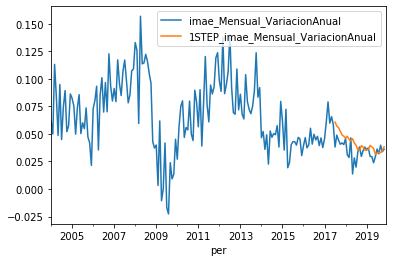

In [33]:
#Evaluacion

bd_eval[y + ['1STEP_' + y[0]]].plot()
r2_out = r2_score(bd_eval_metrics[y],bd_eval_metrics[['1STEP_' + y[0]]]) 
mae_out = mean_absolute_error(bd_eval_metrics[y],bd_eval_metrics[['1STEP_' + y[0]]])
rmse_out = mean_squared_error(bd_eval_metrics[y],bd_eval_metrics[['1STEP_' + y[0]]]) ** 0.5


display(bd_eval_metrics.describe())
display("R2 outsample" + str(r2_out))
display("MAE outsample" + str(mae_out))
display("RMSE outsample" + str(rmse_out))

### Prediccion dos periodos adelante

,imae_Mensual_VariacionAnual,1STEP_imae_Mensual_VariacionAnual,2STEP_imae_Mensual_VariacionAnual,3STEP_imae_Mensual_VariacionAnual
count,27.000000,27.000000,27.000000,27.000000
mean,0.034033,0.040300,0.041881,0.043897
std,0.007638,0.006468,0.007376,0.008661
min,0.013673,0.031579,0.032334,0.031818
25%,0.029523,0.035269,0.035633,0.036738
50%,0.034922,0.038293,0.040571,0.040879
75%,0.039001,0.045360,0.048089,0.050162
max,0.046417,0.055740,0.057870,0.064413


'R2 outsample-1.6413229006266277'

'MAE outsample0.009214778345298451'

'RMSE outsample0.012181294518643875'

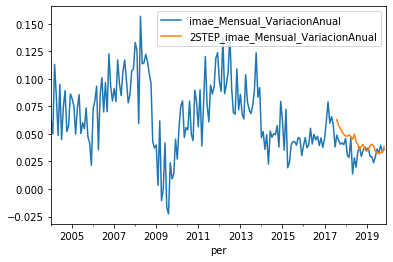

In [34]:

#Evaluacion

bd_eval[y + ['2STEP_' + y[0]]].plot()
r2_out = r2_score(bd_eval_metrics[y],bd_eval_metrics[['2STEP_' + y[0]]]) 
mae_out = mean_absolute_error(bd_eval_metrics[y],bd_eval_metrics[['2STEP_' + y[0]]])
rmse_out = mean_squared_error(bd_eval_metrics[y],bd_eval_metrics[['2STEP_' + y[0]]]) ** 0.5


display(bd_eval_metrics.describe())
display("R2 outsample" + str(r2_out))
display("MAE outsample" + str(mae_out))
display("RMSE outsample" + str(rmse_out))

### Prediccion tres periodos adelante

,imae_Mensual_VariacionAnual,1STEP_imae_Mensual_VariacionAnual,2STEP_imae_Mensual_VariacionAnual,3STEP_imae_Mensual_VariacionAnual
count,27.000000,27.000000,27.000000,27.000000
mean,0.034033,0.040300,0.041881,0.043897
std,0.007638,0.006468,0.007376,0.008661
min,0.013673,0.031579,0.032334,0.031818
25%,0.029523,0.035269,0.035633,0.036738
50%,0.034922,0.038293,0.040571,0.040879
75%,0.039001,0.045360,0.048089,0.050162
max,0.046417,0.055740,0.057870,0.064413


'R2 outsample-2.684826545491341'

'MAE outsample0.010778371022195905'

'RMSE outsample0.014387694905532532'

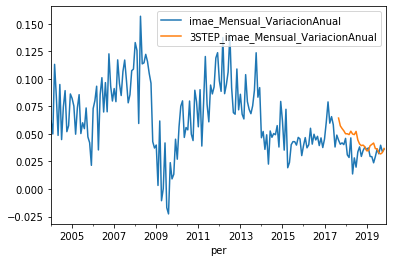

In [35]:

#Evaluacion

bd_eval[y + ['3STEP_' + y[0]]].plot()
r2_out = r2_score(bd_eval_metrics[y],bd_eval_metrics[['3STEP_' + y[0]]]) 
mae_out = mean_absolute_error(bd_eval_metrics[y],bd_eval_metrics[['3STEP_' + y[0]]])
rmse_out = mean_squared_error(bd_eval_metrics[y],bd_eval_metrics[['3STEP_' + y[0]]]) ** 0.5


display(bd_eval_metrics.describe())
display("R2 outsample" + str(r2_out))
display("MAE outsample" + str(mae_out))
display("RMSE outsample" + str(rmse_out))

In [36]:
bd_eval


,imae_Mensual_VariacionAnual,1STEP_imae_Mensual_VariacionAnual,2STEP_imae_Mensual_VariacionAnual,3STEP_imae_Mensual_VariacionAnual
per,,,,
2004-01-01,0.061897,NaN,NaN,NaN
2004-02-01,0.049983,NaN,NaN,NaN
2004-03-01,0.113209,NaN,NaN,NaN
2004-04-01,0.083952,NaN,NaN,NaN
2004-05-01,0.048694,NaN,NaN,NaN
...,...,...,...,...
2019-08-01,0.031975,0.033364,0.032334,0.032819
2019-09-01,0.039755,0.033004,0.033188,0.031818
2019-10-01,0.033907,0.034763,0.033028,0.033093


In [37]:
bd_eval[-10:]

,imae_Mensual_VariacionAnual,1STEP_imae_Mensual_VariacionAnual,2STEP_imae_Mensual_VariacionAnual,3STEP_imae_Mensual_VariacionAnual
per,,,,
2019-03-01,0.029596,0.039550,0.039391,0.039280
2019-04-01,0.029352,0.038293,0.040689,0.040472
2019-05-01,0.023801,0.036845,0.039013,0.041737
2019-06-01,0.029463,0.031579,0.034472,0.036659
2019-07-01,0.036311,0.032585,0.033159,0.036497
2019-08-01,0.031975,0.033364,0.032334,0.032819
2019-09-01,0.039755,0.033004,0.033188,0.031818
2019-10-01,0.033907,0.034763,0.033028,0.033093
2019-11-01,0.036137,0.038283,0.038661,0.036817
